<a href="https://colab.research.google.com/github/malduwais/WordEmbeddingArabicWeb16/blob/master/notebook_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers datasets accelerate xformers -qU
# !pip install seqeval evaluate wandb pytorch-crf spacy optuna -qU

In [ ]:
# fix random seed to 42
import torch
import random
import numpy as np
import transformers

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("conllpp")

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
raw_datasets["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
raw_datasets = raw_datasets.remove_columns(["chunk_tags"])

In [ ]:
raw_datasets["test_es"] = load_dataset("conll2002", "es", split="test")
raw_datasets["test_nl"] = load_dataset("conll2002", "nl", split="test")

In [ ]:
label_names = raw_datasets["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [ ]:
raw_datasets = raw_datasets.remove_columns(["id", "pos_tags"])

In [ ]:
def readfile(filename, enc="utf-8", sep=" "):
    f = open(filename, encoding=enc)
    data = []
    sentence = []
    label = []
    for line in f:
        if len(line) == 0 or line.startswith("-DOCSTART") or line[0] == "\n":
            # check if line has content
            if len(sentence) > 0:
                # if line has no content, construct a new sentence
                data.append((sentence, label))
                sentence = []
                label = []
            continue
        splits = line.split(sep)
        sentence.append(splits[0])
        label.append(splits[-1][:-1])
    return data

In [ ]:
arabic_test = "./aner_test_updated.txt"

In [ ]:
data = readfile(arabic_test)

In [ ]:
# change the PERS label to PER
data = [(ws, [l if l[2:] != "PERS" else l[:-1] for l in ls]) for (ws, ls) in data]

In [ ]:
# change labels to index instead
data = [(ws, [label_names.index(l) for l in ls]) for (ws, ls) in data]

In [ ]:
print(data[6][0])

['شركات', 'موجة', 'الهجمات', 'الانتحارية', 'التي', 'هزت', 'أفغانستان', 'هذا', 'الشهر', '(', 'منها', 'ثلاث', 'هجمات', 'يوم', 'الاثنين', '،', 'وهو', 'ما', 'رفع', 'مجموع', 'هذه', 'الهجمات', 'منذ', '2005', 'إلى', '69', ')', 'تذكيراً', 'محزناً', 'بأن', 'وزير', 'الدفاع', 'دونالد', 'رامسفيلد', '،', 'الذي', 'يتعرض', 'حالياً', 'لانتقادات', 'لاذعة', 'لدوره', 'في', 'العراق', '،', 'لم', 'يكن', 'مهندس', 'حرب', 'فاشلة', 'واحدة', '،', 'بل', 'حربين', 'فاشلتين', '،', 'وصاحب', 'رؤية', 'خطيرة', 'حول', 'كيفية', 'استعمال', 'القوة', 'الأميركية', '.']


In [ ]:
# # remove punctuation
# # running this cell will cause the data to be different from the standards.

# import string
# from unicodedata import category

# # https://en.wikipedia.org/wiki/Unicode_character_property

# new_data = []

# for ws, ls in data:
#     words, labels = [], []
#     for i in range(len(ws)):
#         if len(ws[i]) > 1:
#             words.append(ws[i])
#             labels.append(ls[i])
#         # elif len(ws[i]) == 1:
#         else:
#             # this may be a punctuation
#             if ws[i] not in string.punctuation and category(ws[i])[0] != "P":
#                 words.append(ws[i])
#                 labels.append(ls[i])
#     new_data.append((words, labels))


# data = new_data.copy()

In [ ]:
print(data[6][0])

['شركات', 'موجة', 'الهجمات', 'الانتحارية', 'التي', 'هزت', 'أفغانستان', 'هذا', 'الشهر', '(', 'منها', 'ثلاث', 'هجمات', 'يوم', 'الاثنين', '،', 'وهو', 'ما', 'رفع', 'مجموع', 'هذه', 'الهجمات', 'منذ', '2005', 'إلى', '69', ')', 'تذكيراً', 'محزناً', 'بأن', 'وزير', 'الدفاع', 'دونالد', 'رامسفيلد', '،', 'الذي', 'يتعرض', 'حالياً', 'لانتقادات', 'لاذعة', 'لدوره', 'في', 'العراق', '،', 'لم', 'يكن', 'مهندس', 'حرب', 'فاشلة', 'واحدة', '،', 'بل', 'حربين', 'فاشلتين', '،', 'وصاحب', 'رؤية', 'خطيرة', 'حول', 'كيفية', 'استعمال', 'القوة', 'الأميركية', '.']


In [ ]:
from datasets import Dataset

raw_datasets["test_ar"] = Dataset.from_dict(
    {"tokens": [ws for ws, _ in data], "ner_tags": [ls for _, ls in data]}
)

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
    test_es: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1518
    })
    test_nl: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5196
    })
    test_ar: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 924
    })
})

**The following 4 cells updates the labels by removing the MISC label**

In [ ]:
raw_datasets["train"][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
def change_labels(batch):
    batch["ner_tags"] = [
        [l if "MISC" not in label_names[l] else label_names.index("O") for l in ls]
        for ls in batch["ner_tags"]
    ]
    return batch


raw_datasets = raw_datasets.map(change_labels, batched=True)

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

In [ ]:
raw_datasets["train"][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': [3, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
label_names = label_names[:-2]
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

['<s>',
 '▁EU',
 '▁re',
 'ject',
 's',
 '▁German',
 '▁call',
 '▁to',
 '▁boy',
 'cot',
 't',
 '▁British',
 '▁la',
 'mb',
 '▁',
 '.',
 '</s>']

In [ ]:
inputs.word_ids()

[None, 0, 1, 1, 1, 2, 3, 4, 5, 5, 5, 6, 7, 7, 8, 8, None]

In [ ]:
def align_labels_to_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

In [ ]:
print(raw_datasets["train"][0]["ner_tags"])
print(align_labels_to_tokens(raw_datasets["train"][0]["ner_tags"], inputs.word_ids()))

[3, 0, 0, 0, 0, 0, 0, 0, 0]
[-100, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [ ]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], is_split_into_words=True, truncation=True
    )

    new_labels = []
    all_labels = batch["ner_tags"]
    for i, labels in enumerate(all_labels):
        new_labels.append(align_labels_to_tokens(labels, tokenized_inputs.word_ids(i)))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets["train"][0]

{'input_ids': [0,
  3747,
  456,
  75161,
  7,
  30839,
  11782,
  47,
  25299,
  47924,
  18,
  56101,
  21,
  6492,
  6,
  5,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0, -100],
        [-100,    1,    2,    2, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100]])

In [ ]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 1, 2, 2, -100]


In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
metric

EvaluationModule(name: "seqeval", module_type: "metric", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of sha

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [ ]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    clean_labels = [[label_names[l] for l in ls if l != -100] for ls in labels]
    clean_preds = [
        [label_names[p] for (p, l) in zip(ps, ls) if l != -100]
        for (ps, ls) in zip(preds, labels)
    ]

    metrics = metric.compute(predictions=clean_preds, references=clean_labels)
    overall_metrics = {
        "accuracy": metrics["overall_accuracy"],
        "precision": metrics["overall_precision"],
        "recall": metrics["overall_recall"],
        "f1": metrics["overall_f1"],
    }
    return overall_metrics

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Model without CRF

Use the following cell in case of models with cross entropy loss instead of crf loss

In [ ]:
# DONT RUN THIS CELL. USE THE MODEL_INIT FUNCTION.

# from transformers import AutoModelForTokenClassification

# model = AutoModelForTokenClassification.from_pretrained(
#     model_ckpt,
#     id2label=id2label,
#     label2id=label2id,
# )

## Model with CRF

The following cells in case of models with crf loss. XLM RoBERTa and mBERT have two different setups as follows. Change the `model_ckpt` accordingly.

### XLM RoBERTa

In [ ]:
import torch.nn as nn
from torchcrf import CRF
from transformers import RobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel


class CRFXLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = RobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.crf = CRF(config.num_labels, batch_first=True)
        # Load and initialize weights
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # Use model body to get encoder representations
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            # remove [CLS] token
            logits_ = logits[:, 1:, :]
            labels_ = labels[:, 1:]
            labels_mask = labels_.ne(-100).int()
            labels_ = labels_ * labels_mask
            attention_mask_ = attention_mask[:, 1:]
            loss = -1 * self.crf(
                emissions=logits_,
                tags=labels_,
                mask=attention_mask_.bool(),
                reduction="mean",
            )
        # Return model output object
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### mBERT

In [ ]:
# import torch.nn as nn
# from torchcrf import CRF
# from transformers import BertConfig
# from transformers.modeling_outputs import TokenClassifierOutput
# from transformers.models.bert.modeling_bert import BertModel
# from transformers.models.bert.modeling_bert import BertPreTrainedModel


# class CRFMBERTForTokenClassification(BertPreTrainedModel):
#     config_class = BertConfig

#     def __init__(self, config):
#         super().__init__(config)
#         self.num_labels = config.num_labels
#         # Load model body
#         self.bert = BertModel(config, add_pooling_layer=False)
#         # Set up token classification head
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = nn.Linear(config.hidden_size, config.num_labels)
#         self.crf = CRF(config.num_labels, batch_first=True)
#         # Load and initialize weights
#         self.init_weights()

#     def forward(self, input_ids=None, attention_mask=None,
#                 token_type_ids=None, labels=None, **kwargs):
#         # Use model body to get encoder representations
#         outputs = self.bert(input_ids, attention_mask=attention_mask,
#                             token_type_ids=token_type_ids, **kwargs)
#         # Apply classifier to encoder representation
#         sequence_output = self.dropout(outputs[0])
#         logits = self.classifier(sequence_output)
#         # Calculate losses
#         loss = None
#         if labels is not None:
#             # remove [CLS] token
#             logits_ = logits[:, 1:, :]
#             labels_ = labels[:, 1:]
#             labels_mask = labels_.ne(-100).int()
#             labels_ = labels_ * labels_mask
#             attention_mask_ = attention_mask[:, 1:]
#             loss = -1 * self.crf(emissions=logits_, tags=labels_,
#                                  mask=attention_mask_.bool(), reduction="mean")
#         # Return model output object
#         return TokenClassifierOutput(loss=loss, logits=logits,
#                                      hidden_states=outputs.hidden_states,
#                                      attentions=outputs.attentions)

The `model_init` function works in case of hyperparameter tuning and cover all the models types (with and without CRF).

In [ ]:
from transformers import AutoConfig, AutoModelForTokenClassification


def model_init():
    roberta_config = AutoConfig.from_pretrained(
        model_ckpt, num_labels=len(label_names), id2label=id2label, label2id=label2id
    )
    # with CRF loss XLM RoBERTa
    model = CRFXLMRobertaForTokenClassification.from_pretrained(
        model_ckpt, config=roberta_config
    )
    # # with CRF loss mBERT
    # model = CRFMBERTForTokenClassification.from_pretrained(model_ckpt, config=bert_config)
    # # without CRF XLM RoBERTa and mBERT
    # model = AutoModelForTokenClassification.from_pretrained(model_ckpt,
    #                                                         id2label=id2label,
    #                                                         label2id=label2id)
    return model

In [ ]:
from transformers import TrainingArguments

In [ ]:
model_name = "xlmroberta-finetuned-ner-crf"  # put the name of your output model
model_path = f"models/{model_name}"

In [ ]:
# args = TrainingArguments(
#     model_path,
#     overwrite_output_dir=True,
#     load_best_model_at_end=False,
#     # metric_for_best_model="f1",
#     evaluation_strategy="epoch",
#     save_strategy="no",
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     learning_rate=5e-5,
#     num_train_epochs=3,
#     weight_decay=0.001,
#     warmup_ratio=0.2,
#     seed=seed, data_seed=seed,
# )

In [ ]:
from transformers import Trainer

In [ ]:
# trainer = Trainer(
#     args=args,
#     model_init=model_init,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
#     tokenizer=tokenizer,
# )

In [ ]:
# # hp tuning
# def hp_space(trial):
#     return {"per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32, 64]),
#             "learning_rate": trial.suggest_categorical("learning_rate", [1e-5, 2e-5, 3e-5, 4e-5, 5e-5]),
#             "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 1e-3, 1e-4, 1e-5])}

In [ ]:
# def compute_objective(metrics):
#     return metrics["eval_f1"]

In [ ]:
import json
import wandb

with open("./access_tokens.json") as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

True

In [ ]:
# # wandb.init(project="cross-lingual-ner", config={"CRF": True}, name="xlmroberta-crf-en-hp-search")
# %env WANDB_PROJECT=cross-lingual-ner

In [ ]:
# import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
# best_run = trainer.hyperparameter_search(n_trials=5, direction="maximize",
#                                          backend="optuna", compute_objective=compute_objective,
#                                          hp_space=hp_space, storage="sqlite:///optuna_xlmroberta_ner.db")

In [ ]:
# wandb.finish()

In [ ]:
# best_run

In [ ]:
wandb.init(project="cross-lingual-ner", config={"CRF": True}, name=model_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
args = TrainingArguments(
    model_path,
    overwrite_output_dir=True,
    num_train_epochs=3,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    seed=seed,
    data_seed=seed,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.001,
    warmup_ratio=0.05,
)

In [ ]:
trainer = Trainer(
    model=model_init(),
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

Some weights of CRFXLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'crf.end_transitions', 'crf.transitions', 'crf.start_transitions']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.085646,0.987067,0.915211,0.939641,0.927266
2,4.535800,0.798569,0.990543,0.941790,0.953984,0.947848
3,0.750300,0.850363,0.990666,0.943396,0.956175,0.949743


TrainOutput(global_step=1317, training_loss=2.1382826078816084, metrics={'train_runtime': 356.8815, 'train_samples_per_second': 118.031, 'train_steps_per_second': 3.69, 'total_flos': 1320211483703280.0, 'train_loss': 2.1382826078816084, 'epoch': 3.0})

In [ ]:
trainer.evaluate(tokenized_datasets["test"], metric_key_prefix="test_en")

{'test_en_loss': 1.2156037092208862,
 'test_en_accuracy': 0.9835531279234693,
 'test_en_precision': 0.9159713945172825,
 'test_en_recall': 0.9260895762201246,
 'test_en_f1': 0.9210026964945572,
 'test_en_runtime': 6.6173,
 'test_en_samples_per_second': 521.812,
 'test_en_steps_per_second': 16.321,
 'epoch': 3.0}

In [ ]:
trainer.evaluate(tokenized_datasets["test_es"], metric_key_prefix="test_es")

{'test_es_loss': 4.651081085205078,
 'test_es_accuracy': 0.9741581606944905,
 'test_es_precision': 0.7760119940029985,
 'test_es_recall': 0.8039763901832867,
 'test_es_f1': 0.7897467195605737,
 'test_es_runtime': 5.7964,
 'test_es_samples_per_second': 261.886,
 'test_es_steps_per_second': 8.281,
 'epoch': 3.0}

In [ ]:
trainer.evaluate(tokenized_datasets["test_nl"], metric_key_prefix="test_nl")

{'test_nl_loss': 1.4585756063461304,
 'test_nl_accuracy': 0.9788021298143933,
 'test_nl_precision': 0.7645238913716054,
 'test_nl_recall': 0.8084332969829153,
 'test_nl_f1': 0.7858657243816255,
 'test_nl_runtime': 12.288,
 'test_nl_samples_per_second': 422.851,
 'test_nl_steps_per_second': 13.265,
 'epoch': 3.0}

In [ ]:
trainer.evaluate(tokenized_datasets["test_ar"], metric_key_prefix="test_ar")

{'test_ar_loss': 8.910006523132324,
 'test_ar_accuracy': 0.9507726103996605,
 'test_ar_precision': 0.6140035906642729,
 'test_ar_recall': 0.6312874942316566,
 'test_ar_f1': 0.6225255972696245,
 'test_ar_runtime': 3.7941,
 'test_ar_samples_per_second': 243.533,
 'test_ar_steps_per_second': 7.643,
 'epoch': 3.0}

In [ ]:
wandb.finish()

eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▁▂
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁█▄
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
test/ar_accuracy,▁
test/ar_f1,▁
test/ar_loss,▁


In [ ]:
trainer.save_model(model_name)

In [ ]:
from torch.nn.functional import cross_entropy

device = "cuda" if torch.cuda.is_available() else "cpu"


def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
        # Calculate loss per token after flattening batch dimension with view
        loss = cross_entropy(
            output.logits.view(-1, len(label_names)), labels.view(-1), reduction="none"
        )
        # Unflatten batch dimension and convert to numpy array
        loss = loss.view(len(input_ids), -1).cpu().numpy()
        return {"loss": loss, "predicted_label": predicted_label}

In [ ]:
test_set = tokenized_datasets["test_ar"]
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7f5dc35d9430> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/924 [00:00<?, ? examples/s]

In [ ]:
id2label[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [id2label[i] for i in x])
df["loss"] = df.apply(lambda x: x["loss"][: len(x["input_ids"])], axis=1)
df["labels"] = df["labels"].apply(lambda x: [id2label[i] for i in x])
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][: len(x["input_ids"])], axis=1
)
df = df.reset_index(drop=True)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 184285, 648, 906, 136193, 20, 9475, 86765,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-LOC, I-LOC, B-LOC, I-LOC, O, B-PER, I-...","[0.0, 0.112924896, 0.48242658, 5.0866833, 0.99...","[O, B-LOC, I-LOC, I-LOC, I-ORG, O, B-PER, I-PE...","[<s>, ▁الصالح, ية, ▁الم, فرق, ▁-, ▁غ, يث, ▁الط..."


In [ ]:
import pandas as pd

df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens[df_tokens.labels != "IGN"]
df_tokens = df_tokens.reset_index(drop=True)
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(10)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,184285,1,B-LOC,0.11,B-LOC,▁الصالح
1,648,1,I-LOC,0.48,I-LOC,ية
2,906,1,B-LOC,5.09,I-LOC,▁الم
3,136193,1,I-LOC,1.00,I-ORG,فرق
4,20,1,O,0.01,O,▁-
5,9475,1,B-PER,0.40,B-PER,▁غ
6,86765,1,I-PER,0.07,I-PER,يث
7,35717,1,I-PER,0.06,I-PER,▁الط
8,6247,1,I-PER,0.05,I-PER,را
9,56518,1,I-PER,0.07,I-PER,ونة


In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(15)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
input_tokens,▁و,▁,▁ل,▁لل,▁ب,ي,▁وال,ا,▁ال,▁بال,ة,إسرائيل,▁المتحدة,وا,الولايات
count,305,1890,178,193,214,415,116,371,462,104,593,9,52,59,7
mean,1.67,0.13,0.97,0.83,0.68,0.23,0.76,0.22,0.15,0.64,0.1,5.99,0.95,0.83,6.79
sum,510.72,251.78,172.34,159.43,144.88,95.71,88.23,82.94,69.48,66.11,59.84,53.88,49.28,48.79,47.52


In [ ]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,B-PER,B-LOC,I-ORG,I-LOC,I-PER,O
count,506,890,725,868,826,2380,33864
mean,2.03,1.45,1.43,0.97,0.95,0.6,0.05
sum,1027.06,1293.88,1040.3,837.75,782.64,1422.99,1831.61


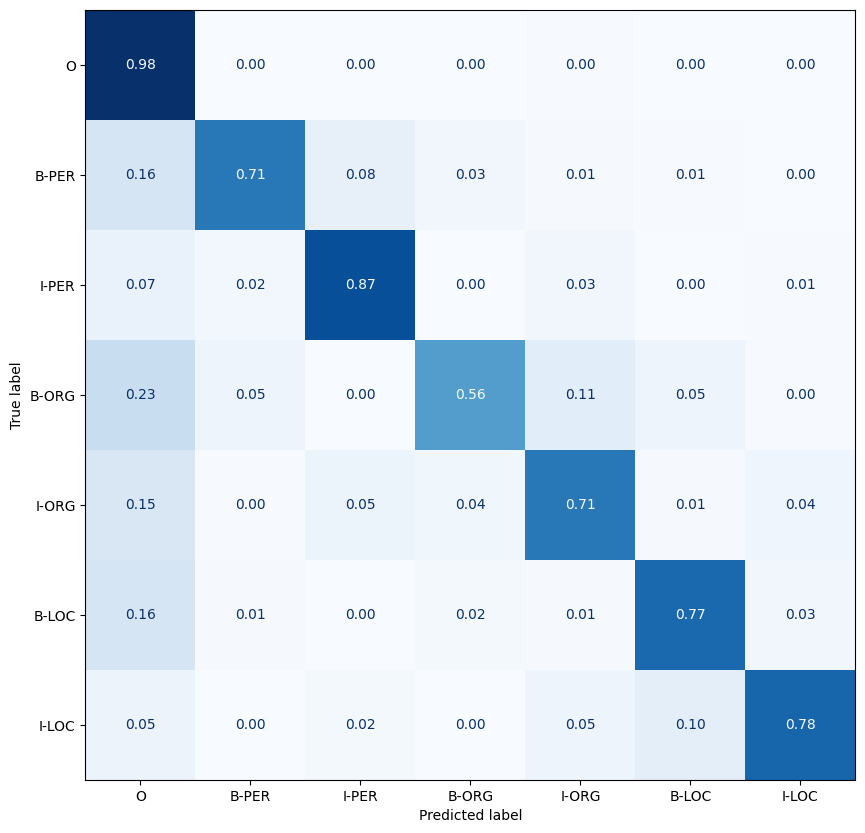

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(
    df_tokens.labels.to_list(),
    df_tokens.predicted_label.to_list(),
    labels=label_names,
    normalize="true",
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues", colorbar=False, ax=ax, values_format=".2f")
plt.show()

In [ ]:
from transformers import pipeline

ner_pipeline = pipeline("ner", model=model_name, aggregation_strategy="simple")

In [ ]:
text = " ".join(raw_datasets["test_ar"][0]["tokens"])
text

'الصالحية المفرق - غيث الطراونة - أمر جلالة الملك عبدالله الثاني أمس بتنفيذ حزمة من المشاريع التعليمية والصحية والتنموية وأخرى مرتبطة بالأندية الشبابية و 27 وحدة سكنية في قضاء الصالحية ونايفة في البادية الشرقية خلال ستة اشهر بتمويل من الديوان الملكي الهاشمي .'

In [ ]:
outs = ner_pipeline(text)

In [ ]:
outs

[{'entity_group': 'LOC',
  'score': 0.6466204,
  'word': 'الصالحية الم',
  'start': 0,
  'end': 12},
 {'entity_group': 'ORG',
  'score': 0.43030322,
  'word': 'فرق',
  'start': 12,
  'end': 15},
 {'entity_group': 'PER',
  'score': 0.886985,
  'word': 'غيث الطراونة',
  'start': 18,
  'end': 30},
 {'entity_group': 'PER',
  'score': 0.76778704,
  'word': 'عبدالله الثاني',
  'start': 49,
  'end': 63},
 {'entity_group': 'LOC',
  'score': 0.964115,
  'word': 'الصالحية ونايفة',
  'start': 175,
  'end': 190},
 {'entity_group': 'LOC',
  'score': 0.9836382,
  'word': 'البادية الشرقية',
  'start': 194,
  'end': 209},
 {'entity_group': 'ORG',
  'score': 0.74061996,
  'word': 'الديوان الملكي',
  'start': 234,
  'end': 248},
 {'entity_group': 'ORG',
  'score': 0.66750926,
  'word': 'اشمي',
  'start': 252,
  'end': 256}]

In [ ]:
def create_scheme(text, outs):
    scheme = {}
    scheme["text"] = text
    scheme["ents"] = [
        {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
        for ent in outs
    ]
    scheme["title"] = None
    return scheme

In [ ]:
from IPython.display import HTML

In [ ]:
from spacy import displacy

In [ ]:
_ = HTML(displacy.render(create_scheme(text, outs), style="ent", manual=True))